In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
eps = np.finfo(float).eps
import matplotlib
import matplotlib.pyplot as plt
import copy

In [22]:
df=pd.read_csv("train.csv")

In [20]:
mid_point={}
mid_point.clear()
class nodestructure:
    def __init__(self, value, pos=0, neg=0, left=None, right=None):
        self.value=value
        self.left=left
        self.right=right
        self.positive=pos
        self.negative=neg

In [23]:
left=df['left']
df=df.drop(columns=['left'])
df = pd.concat([df,pd.get_dummies(df['sales'], prefix='sales')],axis=1)
df = pd.concat([df,pd.get_dummies(df['salary'], prefix='salary')],axis=1)
df.drop(['sales','salary'],axis=1, inplace=True)
df=df.join(left)

In [25]:
numericalfeatures = ['number_project','last_evaluation','satisfaction_level','average_montly_hours','time_spend_company']

In [27]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [29]:
def find_entropy(df):
    target = df.keys()[-1]   
    entropy = 0
    values = df[target].unique()
    for value in values:
        fraction = df[target].value_counts()[value]/(len(df[target])+eps)
        entropy += -fraction*np.log2(fraction+eps)
    return entropy  

In [30]:
def find_entropy_attribute(df,attribute):
    target = df.keys()[-1]   
    #Will return the unique values present in the target column 'left'
    target_variables = df[target].unique() 
    variables = df[attribute].unique()
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[target] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        fraction2 =(den)/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

In [31]:
def get_subtable1(X_train,node,value):
    return X_train[X_train[node] < value].reset_index(drop=True)

def get_subtable2(X_train,node,value):
    return X_train[X_train[node] >= value].reset_index(drop=True)

def get_subtable(df,node,value):
    return df[df[node] == value].reset_index(drop=True)

In [32]:
for feature in numericalfeatures:
    IGMax=0
    midmax=0
    prev=None
    train.sort_values(feature,inplace=True)
    for index,row in train.iterrows():
        if prev is not None:
            if prev['left']!=row['left']:
                mid=(float(prev[feature])+float(row[feature]))/2
                subtable1=get_subtable1(train,feature,mid)
                subtable2=get_subtable2(train,feature,mid)
                firstentropy=0
                secondentropy=0
                if subtable1.empty:
                    firstentropy=0
                else:
                    frac1=float(len(subtable1))/len(train)
                    firstentropy = frac1*find_entropy(subtable1)
                if subtable2.empty:
                    secondentropy=0
                else:
                    frac2=float(len(subtable2))/len(train)
                    secondentropy = frac2*find_entropy(subtable2)
                
                entropy1=find_entropy(train)
                entropy2=firstentropy+secondentropy
                ig=abs(entropy1)-abs(entropy2)
                if ig > IGMax:
                    IGMax=ig
                    midmax=mid

        prev=row
    mid_point[feature]=midmax
#     print mid_point[feature]
    for index,row in train.iterrows():
        if float(row[feature])>=midmax:
            train.at[index,feature]=1
        else:
            train.at[index,feature]=0

/home/vagupta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:       
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]

In [42]:
def buildtree_depth(X_train,depth):
    
    if len(X_train.columns)==1:  
        return 
    output=X_train.keys()[-1]
    bestattr = find_winner(X_train)  
    root=nodestructure(bestattr)
    outputValue,counts = np.unique(X_train[output],return_counts=True)                        
    if len(counts)<=1:   
        if outputValue[0]==0:     
            root.negative=counts[0]
        else:
            root.positive=counts[0]   
            
    else:       
        if outputValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
        if outputValue[1]==0:
            root.negative=counts[1]
        else:
            root.positive=counts[1]

        if depth==0 : 
            return root
        
        attValue=X_train[bestattr].unique() 
        
        for val in attValue:  
            subdataframe = get_subtable(X_train,bestattr,val)                  
            subdataframe=subdataframe.drop([bestattr],axis=1)
            outputValue,counts = np.unique(subdataframe[output],return_counts=True)                        
            if len(counts)<=1:
                pass
            else:
                if val == 1:
                    root.right=buildtree(subdataframe,depth-1)
                else:
                    root.left=buildtree(subdataframe,depth-1)
    return root

In [43]:
def buildtree_nodes(X_train,numberofnodes):
    
    if len(X_train.columns)==1:  
        return 
    output=X_train.keys()[-1]
    bestattr = find_winner(X_train)  
    root=nodestructure(bestattr)
    outputValue,counts = np.unique(X_train[output],return_counts=True)                        
    if len(counts)<=1:   
        if outputValue[0]==0:     
            root.negative=counts[0]
        else:
            root.positive=counts[0]   
            
    else:       
        if outputValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
        if outputValue[1]==0:
            root.negative=counts[1]
        else:
            root.positive=counts[1]

        if numberofnodes==0 : 
            return root
        
        attValue=X_train[bestattr].unique() 
        
        for val in attValue:  
            subdataframe = get_subtable(X_train,bestattr,val)                  
            subdataframe=subdataframe.drop([bestattr],axis=1)
            outputValue,counts = np.unique(subdataframe[output],return_counts=True)                        
            if len(counts)<=1:
                pass
            else:
                if val == 1:
                    numberofnodes-=1
                    if numberofnodes==0 : 
                        return root
                    root.right=buildtree(subdataframe,numberofnodes-1)
                    
                else:
                    numberofnodes-=1
                    if numberofnodes==0 : 
                        return root
                    root.left=buildtree(subdataframe,numberofnodes-1)
                    
    return root

In [44]:
def height(root) :
    if root == None :
        return 0;
    else :
        return 1 + max(height(root.left),height(root.right))

In [46]:
def testing(X_test,root):
    
    if root.left == None and root.right == None:
        if root.positive>root.negative:
            y_pred.append(1)
        else:
            y_pred.append(0)
        return
    
    j = root.value
    if j in X_test:
        if X_test[j] == 1:
            if root.right==None:
                if root.positive>root.negative:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            else:
                testing(X_test,root.right)
        else:
            if root.left==None:
                if root.positive>root.negative:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            else:
                testing(X_test,root.left)
    else:
        if root.left==None:
            if root.positive>root.negative:
                y_pred.append(1)
            else:
                y_pred.append(0)
        else:
            testing(X_test,root.left)

In [36]:
def convert_to_binary(X_test):
    for feature in numericalfeatures:
        for index,row in X_test.iterrows():
            if float(row[feature]) >= mid_point[feature]:
                X_test.at[index,feature]=1
            else:
                X_test.at[index,feature]=0


In [47]:
accuracytest = {}
accuracytrain = {}
for i in xrange(2,21,2):
    print i
    copyXtrain=copy.deepcopy(train)
    copyXtest=copy.deepcopy(test)
    for col in numericalfeatures:
        for index,row in copyXtest.iterrows():
                if float(row[col]) < mid_point[col]:
                    copyXtest.at[index,col]=0
                else:
                    copyXtest.at[index,col]=1

    for col in numericalfeatures:
        for index,row in copyXtrain.iterrows():
                if float(row[col]) < mid_point[col]:
                    copyXtrain.at[index,col]=0
                else:
                    copyXtrain.at[index,col]=1

    root = buildtree_nodes(copyXtrain,i)
#     root =  buildtree_depth(copyXtrain,i)
    
    y_pred = []
    for index,row in copyXtest.iterrows():
        testing(row,root)
    y_test=copyXtest['left']
    accuracytest[i] = 1 - accuracy_score(y_test,y_pred)
    
    del y_pred[:]
    for index,row in copyXtrain.iterrows():
        testing(row,root)
    y_train=copyXtrain['left']
    accuracytrain[i] = 1 - accuracy_score(y_train,y_pred)


2
4
6
8
10
12
14
16
18
20


{2: 0.1774301675977653, 4: 0.16625698324022342, 6: 0.16547486033519554, 8: 0.16312849162011178, 10: 0.16212290502793292, 12: 0.1588826815642458, 14: 0.15541899441340778, 16: 0.14994413407821228, 18: 0.14994413407821228, 20: 0.14994413407821228}
{2: 0.18618881118881114, 4: 0.1700174825174825, 6: 0.16826923076923073, 8: 0.16870629370629375, 10: 0.1647727272727273, 12: 0.16564685314685312, 14: 0.16346153846153844, 16: 0.1621503496503497, 18: 0.1621503496503497, 20: 0.1621503496503497}


Text(0.5,1,'nodes vs error')

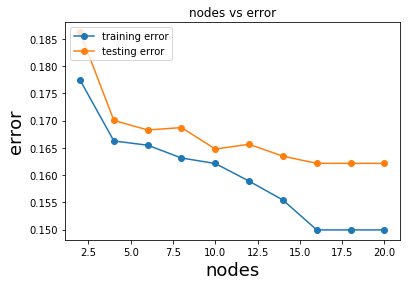

In [49]:
x_axis = [i for i in xrange(2,21,2)]
print accuracytrain
print accuracytest
fig, ax = plt.subplots()
ax.plot(x_axis, accuracytrain.values(), label="training error", marker='o')
ax.plot(x_axis, accuracytest.values(), label="testing error", marker='o')
ax.legend(loc=2) # upper left corner
ax.set_xlabel("nodes", fontsize=18)
ax.set_ylabel("error", fontsize=18)
ax.set_title('nodes vs error')